__Análise de dados Docking__

Caso não tenha alguma des bibliotecas abaixo abra o terminal do Jupyter ou outro programa que esteja usando e digite "pip install nome_da_biblioteca"

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import rmsd
import periodictable as pt
%matplotlib inline  

Esse algoritmo analisa uma pasta com arquivos pdbqt gerados por docking com o vina e as transforma em um dataframe com a posição do centro de mass, valor do RMSD e energia.

Para esse notebook funcionar corretamente, você precisa instalar bibliotecas como, rmsd, periodictable, numpy e pandas.

Qualquer questão escreva para rafael.pleite@usp.br

Funções para extrair os dados dos arquivos .pdbqt

In [2]:
def load(i):
    data = ''
    with open(i) as fp:
        data = fp.read()
    data = data.split('\n')
    return data

def CalcMassAtom(Matrix):
    data = []
    for x in range(len(Matrix)):
        A = Matrix[x].split()
        if len(A) != 0 and A[0] == 'HETATM' and A[2][0] != 'H':
            data.append([A[5], A[6], A[7], A[2][0]])
    return data

def AssingMass(Pos_atom):
    for i in range(len(Pos_atom)): #Change the atom name for atom mass
        for j in range(len(Pos_atom[0])):
            Pos_atom[i][j][3] = MassAtom(Pos_atom[i][j][3])
    return Pos_atom

def PositionAtom(Data_, n_atom):
    Positions = []
    for i in range(0, len(Data_), n_atom):
        Positions.append(Data_[i:n_atom+i])
    return Positions

def MassAtom(At):
    Atom = str(At)
    if Atom == 'C':
        return float(pt.C.mass)
    elif Atom == 'O':
        return float(pt.O.mass)
    elif Atom == 'N':
        return float(pt.N.mass)
    elif Atom == 'F':
        return float(pt.F.mass)
    elif Atom == 'Cl':
        return float(pt.Cl.mass)
    else:
        return None
    
def CM(Pos_mass):
    Matrix = np.array(Pos_mass)
    PositionCM = [float(0), float(0), float(0)]
    M = 0
    for i in range(len(Matrix)):
        M += float(Matrix[i,3])
        PositionCM[0] += float(Matrix[i,0])*float(Matrix[i,3])
        PositionCM[1] += float(Matrix[i,1])*float(Matrix[i,3])
        PositionCM[2] += float(Matrix[i,2])*float(Matrix[i,3])
    return [PositionCM[0]/M, PositionCM[1]/M, PositionCM[2]/M]

def TransformFloat(M):
    P = M
    for i in range(len(P)):
        for j in range(len(P[i])):
            P[i][j] = float(P[i][j])
    return P

Essa parte é vital para o funcionamente correto do código.

Abaixo entre com o caminho da pasta com os arquivos .pdbqt e o correto número de átomos do ligante menos o número de hidrogênios.

Exemplo: Luteolin possui a seguinte fórmula C15H10O6, ou seja, são (31 átomos - 10 átomos de hidrogênios) = 21 átomos

In [3]:
Path = 'C:\SARSCOV2\The Molecular Docking Study of Potential Drug Candidates\Luteolin\LuteolinPLpro\Teste\Resultado'
n_atom = 21

Entre aqui com o nome do arquivo de referencial, isto é, o seu melhor resultado para ser o referencial do sistema que calcula o RMSD

In [4]:
Referential_pos = r'\poteina-ligante,60,23,20,.pdbqt'

In [5]:
Referential = list(np.array(AssingMass(PositionAtom(CalcMassAtom(load(Path + Referential_pos)), n_atom)), float)[0,:,:3])
    
Principal = np.zeros((1,5))
    
if str(input('Digite [S] para analisar todos os arquivos .pdbqt do diretório ou [N] para analisar apenas o seu referencial de RMSD: ')).upper() == 'S':
    for root, directories, files in os.walk(Path, topdown=False):
        for name in files:
            if name.find('pdbqt') != -1:
                Data_load = load(str(Path + r'\b'[0]+ name))
                Data_ = CalcMassAtom(Data_load)
                    
                #Take de coordinates of atom and your name
                Pos_atom = PositionAtom(Data_, n_atom)
                Pos_atom = AssingMass(Pos_atom)
                    
                CM_pos = [] #Calculate de center of mass
                for x in Pos_atom:
                    CM_pos.append(CM(x))
                        
                Array_pos_atom = np.array(Pos_atom, float)
                RMSD = []
                for j in range(len(CM_pos)):
                    RMSD.append(rmsd.rmsd(Referential, list(Array_pos_atom[j,:,:3])))
                    
                Energy = []
                for x in range(len(Data_load)):
                    A = Data_load[x].split()
                    if len(A) >= 3 and A[1] == 'VINA':
                        Energy.append(float(A[3]))
                            
                No_principal = []
                for i in range(len(RMSD)):
                    No_principal.append([CM_pos[i][0], CM_pos[i][1], CM_pos[i][2] ,RMSD[i], Energy[i]])
                No_principal = np.array(No_principal)
                Principal = np.append(Principal, No_principal, axis=0) #add RMSD to principal
                    
else:
    for root, directories, files in os.walk(Path, topdown=False):
        for name in files:
            if name.find(Referential_pos[1:]) != -1:
                Data_load = load(str(Path + r'\b'[0]+ name))
                Data_ = CalcMassAtom(Data_load)
                
                #Take de coordinates of atom and your name
                Pos_atom = PositionAtom(Data_, n_atom)
                Pos_atom = AssingMass(Pos_atom)
                
                CM_pos = [] #Calculate de center of mass
                for x in Pos_atom:
                    CM_pos.append(CM(x))
                        
                Array_pos_atom = np.array(Pos_atom, float)
                RMSD = []
                for j in range(len(CM_pos)):
                    RMSD.append(rmsd.rmsd(Referential, list(Array_pos_atom[j,:,:3])))
                    
                Energy = []
                for x in range(len(Data_load)):
                    A = Data_load[x].split()
                    if len(A) >= 3 and A[1] == 'VINA':
                        Energy.append(float(A[3]))
                            
                No_principal = []
                for i in range(len(RMSD)):
                    No_principal.append([CM_pos[i][0], CM_pos[i][1], CM_pos[i][2] ,RMSD[i], Energy[i]])
                No_principal = np.array(No_principal)
                Principal = np.append(Principal, No_principal, axis=0) #add RMSD to principal
                
Principal = np.delete(Principal, 0, 0)
df = pd.DataFrame(Principal, columns=('x', 'y', 'z', 'RMSD', 'Energy'))

Digite [S] para analisar todos os arquivos .pdbqt do diretório ou [N] para analisar apenas o seu referencial de RMSD: S


Remove os valores de energia > 0.

In [6]:
df = df[df['Energy'] <=0]

Apresenta alguns dados de menores energias.

In [7]:
df.head()

,x,y,z,RMSD,Energy
0,3.935328,95.089459,-13.846279,96.932346,-0.9
1,4.395488,94.775420,-14.316404,96.625758,-0.9
2,5.559979,95.242636,-16.054529,96.904356,-0.8
3,4.471179,95.701049,-16.111890,97.920163,-0.8
4,4.135887,95.328911,-13.597630,96.952183,-0.8


Informações sobre o DataFrame.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1327 entries, 0 to 1329
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1327 non-null   float64
 1   y       1327 non-null   float64
 2   z       1327 non-null   float64
 3   RMSD    1327 non-null   float64
 4   Energy  1327 non-null   float64
dtypes: float64(5)
memory usage: 62.2 KB


Melhores valores de energia.

In [9]:
df.sort_values(by=['Energy']).head(15)

,x,y,z,RMSD,Energy
862,60.466407,23.420901,18.569518,0.000000,-8.9
863,57.449442,23.605323,16.323010,7.509748,-8.8
864,59.734354,23.258545,18.613908,1.302817,-8.7
868,59.639820,24.720453,17.458912,4.569215,-8.3
867,62.952472,23.594100,17.803226,5.698770,-8.3
866,61.753416,23.784689,17.165631,4.687951,-8.3
865,59.455092,23.025756,17.612073,6.919832,-8.3
870,60.904222,22.679563,16.901871,3.893346,-8.2
869,62.229796,22.872163,16.408806,4.477926,-8.2
513,21.222171,77.836166,-3.881246,70.992621,-8.1


__Gráficos__

Aqui vão alguns gráficos de dispersão sem filtragem no valor da energia.

Repare que o gráfico fica muito poluido.

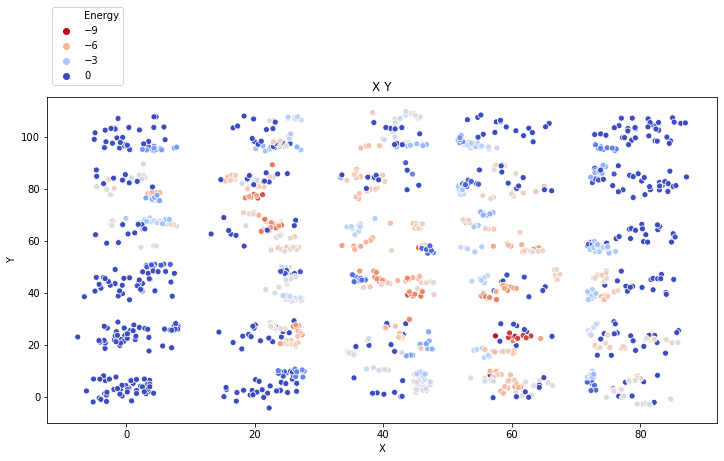

In [10]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='Energy',palette='coolwarm_r')
svm.set_title("X Y")
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
figure = svm.get_figure()    
#para salvar a figura
figure.savefig('XY'+'.png', dpi=600)

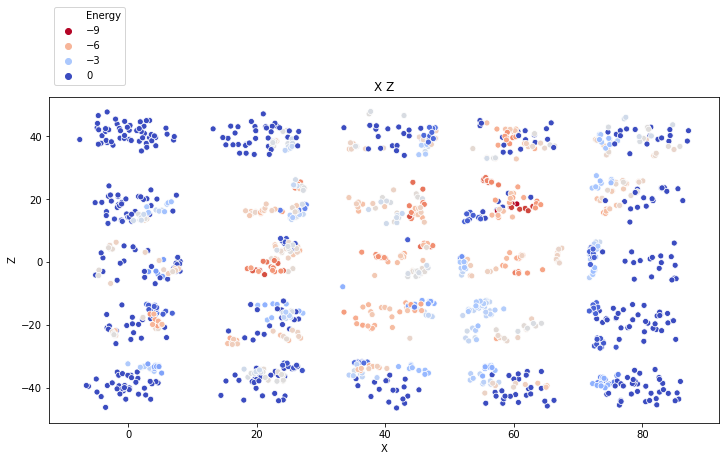

In [11]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='Energy',palette='coolwarm_r')
svm.set_title("X Z")
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
figure = svm.get_figure() 
#para salvar a figura
figure.savefig('XY'+'.png', dpi=600)

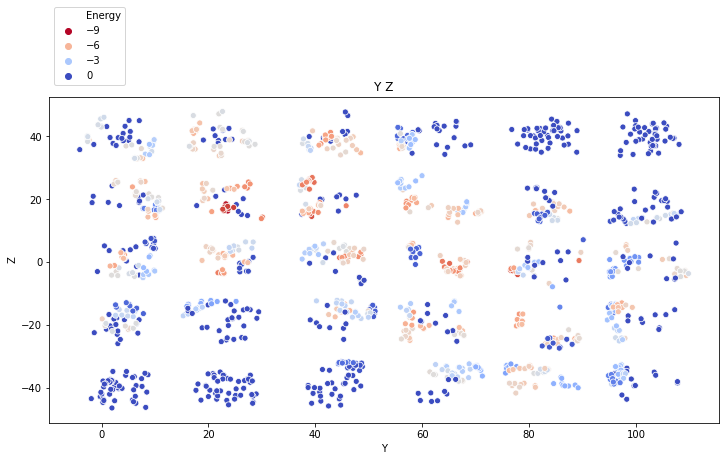

In [12]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='Energy',palette='coolwarm_r')
svm.set_title("Y Z")
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left')
figure = svm.get_figure() 
#para salvar a figura
figure.savefig('XY'+'.png', dpi=600)

Filtro valores de energia <-8 para uma melhor vizualização dos resultados

In [13]:
df = df[df['Energy'] <-8]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 513 to 870
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       10 non-null     float64
 1   y       10 non-null     float64
 2   z       10 non-null     float64
 3   RMSD    10 non-null     float64
 4   Energy  10 non-null     float64
dtypes: float64(5)
memory usage: 480.0 bytes


In [14]:
df

,x,y,z,RMSD,Energy
513,21.222171,77.836166,-3.881246,70.992621,-8.1
862,60.466407,23.420901,18.569518,0.000000,-8.9
863,57.449442,23.605323,16.323010,7.509748,-8.8
864,59.734354,23.258545,18.613908,1.302817,-8.7
865,59.455092,23.025756,17.612073,6.919832,-8.3
866,61.753416,23.784689,17.165631,4.687951,-8.3
867,62.952472,23.594100,17.803226,5.698770,-8.3
868,59.639820,24.720453,17.458912,4.569215,-8.3
869,62.229796,22.872163,16.408806,4.477926,-8.2
870,60.904222,22.679563,16.901871,3.893346,-8.2


O resultados dos gráficos de dispersão são melhores vizualizados assim.

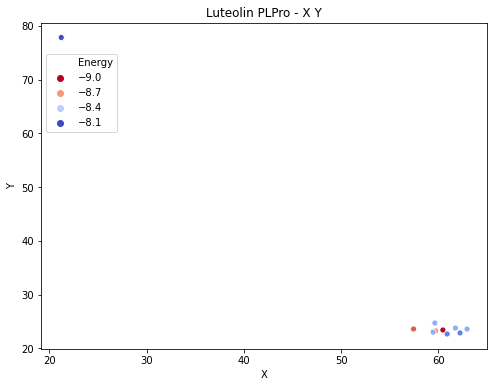

In [15]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='Energy',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.65, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y')
#para salvar a figura
figure.savefig('XY'+'.png', dpi=600)

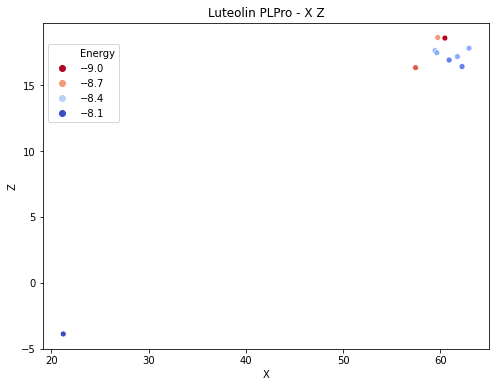

In [16]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='Energy',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.68, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z')
#para salvar a figura
figure.savefig('XZ'+'.png', dpi=600)

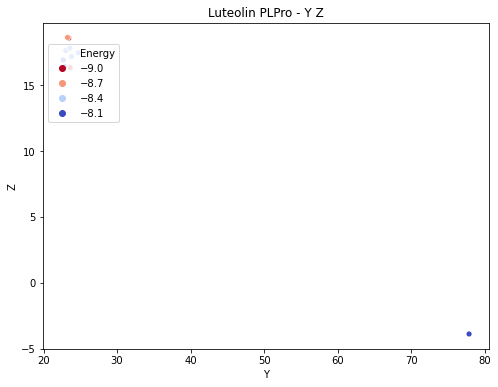

In [17]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='Energy',palette='coolwarm_r')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.68, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z')
#para salvar a figura
figure.savefig('YZ'+'.png', dpi=600)

Aqui temos uma vizualização diferente dos dados. Um histograma 3d.

Caso não tenha o plotly instalado digite "pip install plotly" no terminal.

In [18]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = 'browser'


# plotly setup
fig=go.Figure()

# data binning and traces
for i, col in enumerate(df.columns):
    a0=np.histogram(df[col], bins=10, density=False)[0].tolist()
    a0=np.repeat(a0,2).tolist()
    a0.insert(0,0)
    a0.pop()
    a1=np.histogram(df[col], bins=10, density=False)[1].tolist()
    a1=np.repeat(a1,2)
    fig.add_traces(go.Scatter3d(x=[i]*len(a0), y=a1, z=a0,
                                mode='lines',
                                name=col
                               )
                  )
fig.show()

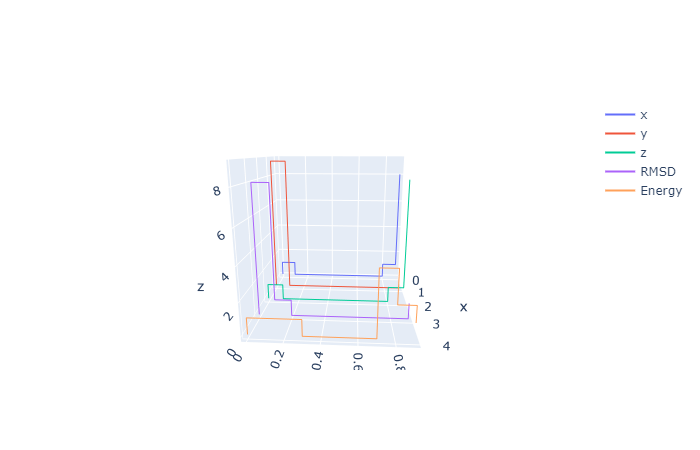

__CLUSTERIZAÇÃO__

Daqui para frente iremos trabalhar com a clusterização dos dados coletados. Fique a vontade para modificar os parâmetros dos algoritmos de clusterização da forma que achar melhor.

__Começamos com o KMeans__

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [20]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df)
y_predicted

array([0, 3, 2, 3, 2, 1, 1, 1, 1, 1])

In [21]:
df['cluster'] = y_predicted

Vizualização do nosso DataFrame com a coluna "cluster"

In [22]:
df.head()

,x,y,z,RMSD,Energy,cluster
513,21.222171,77.836166,-3.881246,70.992621,-8.1,0
862,60.466407,23.420901,18.569518,0.000000,-8.9,3
863,57.449442,23.605323,16.323010,7.509748,-8.8,2
864,59.734354,23.258545,18.613908,1.302817,-8.7,3
865,59.455092,23.025756,17.612073,6.919832,-8.3,2


Gráficos de dispersão clusterizados.

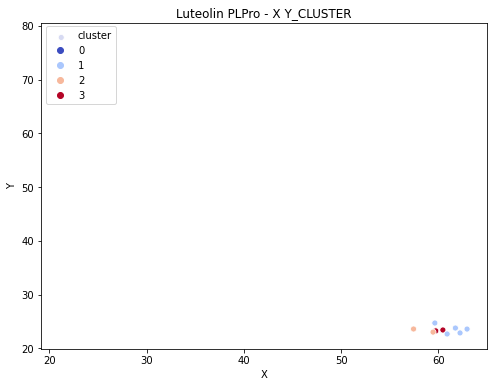

In [23]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER')
#para salvar a figura
figure.savefig('XY_CLUSTER'+'.png', dpi=600)

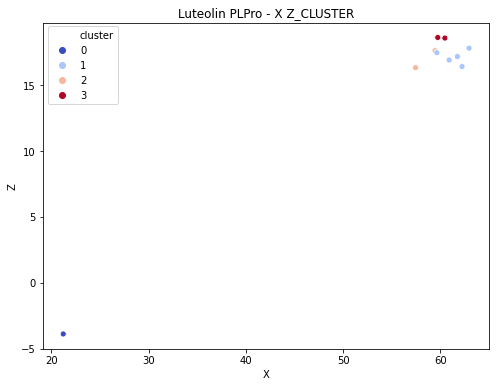

In [24]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER')
#para salvar a figura
figure.savefig('XZ_CLUSTER'+'.png', dpi=600)

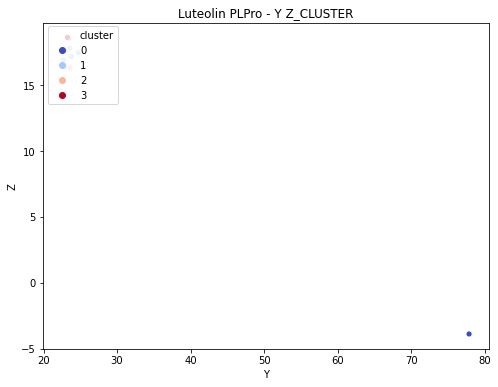

In [25]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER')
#para salvar a figura
figure.savefig('YZ_CLUSTER'+'.png', dpi=600)

__Vamos tentar usar o DBSCAN__

In [26]:
from sklearn.cluster import DBSCAN

In [27]:
df = df.drop('cluster', axis = 1)
df.head()

,x,y,z,RMSD,Energy
513,21.222171,77.836166,-3.881246,70.992621,-8.1
862,60.466407,23.420901,18.569518,0.000000,-8.9
863,57.449442,23.605323,16.323010,7.509748,-8.8
864,59.734354,23.258545,18.613908,1.302817,-8.7
865,59.455092,23.025756,17.612073,6.919832,-8.3


In [28]:
clustering = DBSCAN(eps= 4, min_samples = 5).fit(df)
cluster = clustering.labels_

print(set(cluster), '\n', cluster)
outliers_df = pd.DataFrame(df)

print (outliers_df[cluster==-1])

{0, -1} 
 [-1 -1  0  0  0  0  0  0  0  0]
             x          y          z       RMSD  Energy
513  21.222171  77.836166  -3.881246  70.992621    -8.1
862  60.466407  23.420901  18.569518   0.000000    -8.9


In [29]:
df['cluster']=cluster
df.head()

,x,y,z,RMSD,Energy,cluster
513,21.222171,77.836166,-3.881246,70.992621,-8.1,-1
862,60.466407,23.420901,18.569518,0.000000,-8.9,-1
863,57.449442,23.605323,16.323010,7.509748,-8.8,0
864,59.734354,23.258545,18.613908,1.302817,-8.7,0
865,59.455092,23.025756,17.612073,6.919832,-8.3,0


Gráficos de dispersão clusterizados com o DBS.

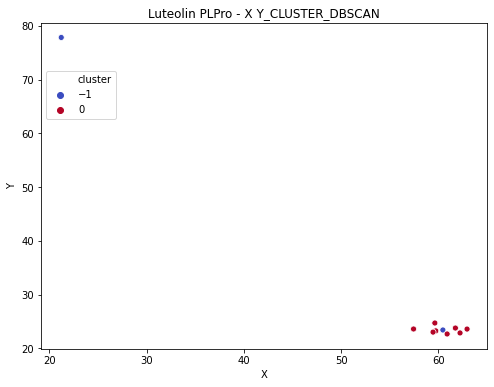

In [30]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.69, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER_DBSCAN')
#para salvar a figura
figure.savefig('XY_CLUSTER_DBSCAN'+'.png', dpi=600)

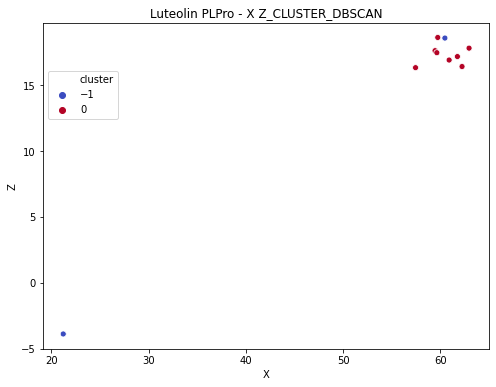

In [31]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.69, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER_DBSCAN')
#para salvar a figura
figure.savefig('XZ_CLUSTER_DBSCAN'+'.png', dpi=600)

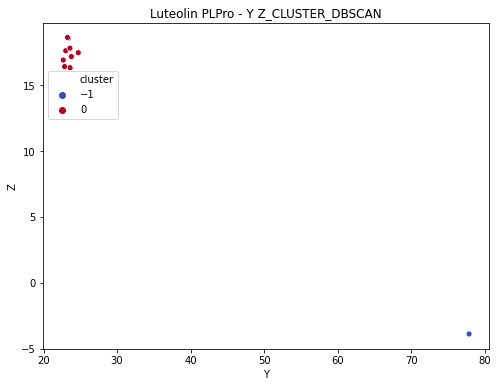

In [32]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.69, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER_DBSCAN')
#para salvar a figura
figure.savefig('YZ_CLUSTER_DBSCAN'+'.png', dpi=600)

__Análise com os dados normalizados__

Agora iremos normalizar os nossos dados, isso significar que todos eles estão na mesma escala [0, 1]. Agora todos tem o mesmo peso na hora de calcular o cluster.

In [33]:
scaler = MinMaxScaler()

scaler.fit(df[['x']])
df['x'] = scaler.transform(df[['x']])

scaler.fit(df[['y']])
df['y'] = scaler.transform(df[['y']])

scaler.fit(df[['z']])
df['z'] = scaler.transform(df[['z']])

scaler.fit(df[['RMSD']])
df['RMSD'] = scaler.transform(df[['RMSD']])

scaler.fit(df[['Energy']])
df['Energy'] = scaler.transform(df[['Energy']])

In [34]:
df = df.drop('cluster', axis=1)
df.head()

,x,y,z,RMSD,Energy
513,0.000000,1.000000,0.000000,1.000000,1.000
862,0.940425,0.013441,0.998027,0.000000,0.000
863,0.868129,0.016784,0.898160,0.105782,0.125
864,0.922883,0.010497,1.000000,0.018351,0.250
865,0.916191,0.006277,0.955464,0.097473,0.750


A vizualização do gráfico de histograma melhora substancialmente.

In [35]:
pio.renderers.default = 'browser'


# plotly setup
fig=go.Figure()

# data binning and traces
for i, col in enumerate(df.columns):
    a0=np.histogram(df[col], bins=10, density=False)[0].tolist()
    a0=np.repeat(a0,2).tolist()
    a0.insert(0,0)
    a0.pop()
    a1=np.histogram(df[col], bins=10, density=False)[1].tolist()
    a1=np.repeat(a1,2)
    fig.add_traces(go.Scatter3d(x=[i]*len(a0), y=a1, z=a0,
                                mode='lines',
                                name=col
                               )
                  )
fig.show()

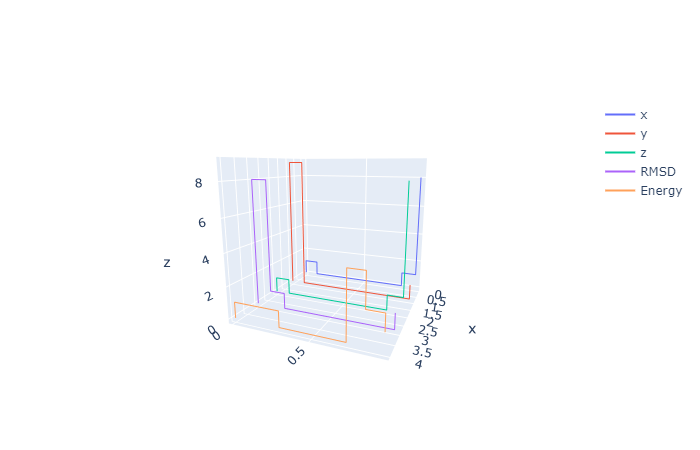

Voltamos com o KMeans.

In [36]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df)
y_predicted

array([0, 3, 2, 2, 1, 1, 1, 1, 1, 1])

In [37]:
df['cluster']=y_predicted
df.head()

,x,y,z,RMSD,Energy,cluster
513,0.000000,1.000000,0.000000,1.000000,1.000,0
862,0.940425,0.013441,0.998027,0.000000,0.000,3
863,0.868129,0.016784,0.898160,0.105782,0.125,2
864,0.922883,0.010497,1.000000,0.018351,0.250,2
865,0.916191,0.006277,0.955464,0.097473,0.750,1


Os gráficos ficam.

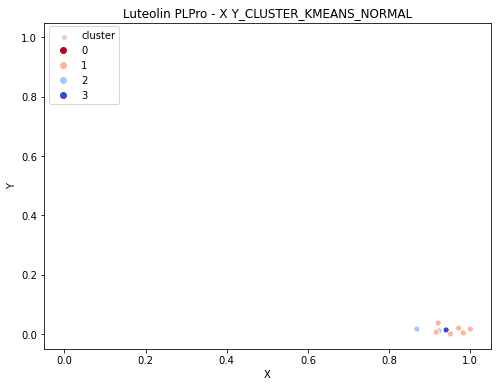

In [38]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER_KMEANS_NORMAL')
figure.savefig('XY_CLUSTER_NORMAL'+'.png', dpi=600)

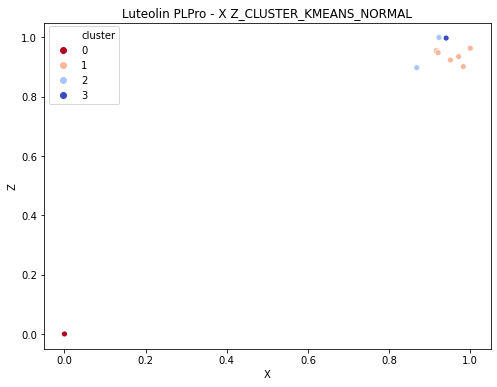

In [39]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm_r')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER_KMEANS_NORMAL')
figure.savefig('XZ_CLUSTER_NORMAL'+'.png', dpi=600)

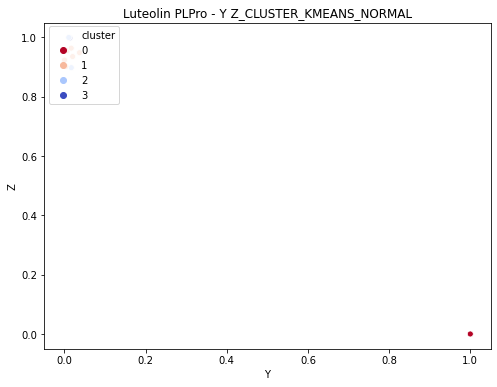

In [40]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm_r')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.735, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER_KMEANS_NORMAL')
figure.savefig('YZ_CLUSTER_NORMAL'+'.png', dpi=600)

__Elbow Method__

In [41]:
df = df.drop('cluster', axis=1)

In [42]:
sse = []
k_rng = range(1,5)
for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)

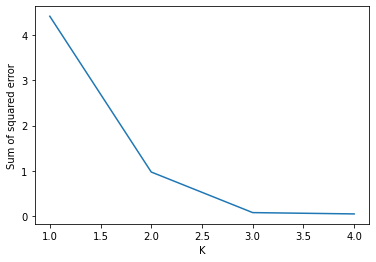

In [43]:
plt.xlabel('K')
plt.ylabel('Sum of squared error')
plt.plot(k_rng,sse)

In [44]:
km = KMeans(n_clusters=2)
y_predicted = km.fit_predict(df)

df['cluster']=y_predicted

Agora, voltamos para o DBSCAN normalizado.

In [45]:
df = df.drop('cluster', axis=1)
df.head()

,x,y,z,RMSD,Energy
513,0.000000,1.000000,0.000000,1.000000,1.000
862,0.940425,0.013441,0.998027,0.000000,0.000
863,0.868129,0.016784,0.898160,0.105782,0.125
864,0.922883,0.010497,1.000000,0.018351,0.250
865,0.916191,0.006277,0.955464,0.097473,0.750


In [46]:
clustering = DBSCAN(eps= 0.3, min_samples = 5).fit(df)
cluster = clustering.labels_

print(set(cluster), '\n', cluster)
outliers_df = pd.DataFrame(df)

print (outliers_df[cluster==-1])

{0, -1} 
 [-1 -1 -1 -1  0  0  0  0  0  0]
            x         y         z      RMSD  Energy
513  0.000000  1.000000  0.000000  1.000000   1.000
862  0.940425  0.013441  0.998027  0.000000   0.000
863  0.868129  0.016784  0.898160  0.105782   0.125
864  0.922883  0.010497  1.000000  0.018351   0.250


In [47]:
df['cluster']=cluster
df.head()

,x,y,z,RMSD,Energy,cluster
513,0.000000,1.000000,0.000000,1.000000,1.000,-1
862,0.940425,0.013441,0.998027,0.000000,0.000,-1
863,0.868129,0.016784,0.898160,0.105782,0.125,-1
864,0.922883,0.010497,1.000000,0.018351,0.250,-1
865,0.916191,0.006277,0.955464,0.097473,0.750,0


Os gráficos ficam.

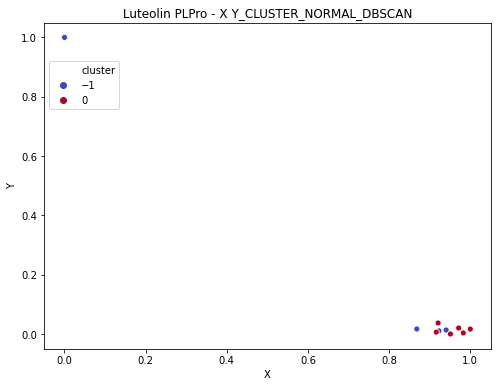

In [48]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='y',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Y")

plt.legend(bbox_to_anchor=(0., 0.72, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Y_CLUSTER_NORMAL_DBSCAN')
figure.savefig('XY_CLUSTER_NORMAL_DBSCAN'+'.png', dpi=600)

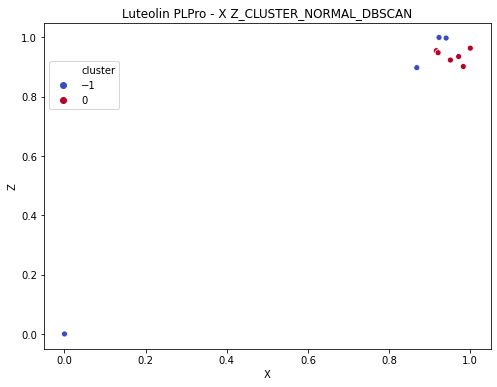

In [49]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='x', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("X")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.72, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - X Z_CLUSTER_NORMAL_DBSCAN')
figure.savefig('XZ_CLUSTER_NORMAL_DBSCAN'+'.png', dpi=600)

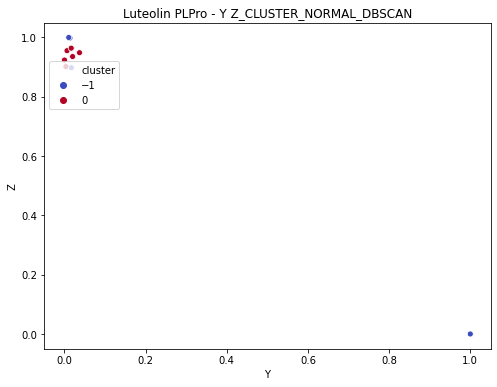

In [50]:
ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(8,6))

svm = sns.scatterplot(data=df,x='y', y='z',hue='cluster',palette='coolwarm')
plt.xlabel("Y")
plt.ylabel("Z")

plt.legend(bbox_to_anchor=(0., 0.72, 1., .10), loc='lower left')
figure = svm.get_figure()    
plt.title('Luteolin PLPro - Y Z_CLUSTER_NORMAL_DBSCAN')
figure.savefig('YZ_CLUSTER_NORMAL_DBSCAN'+'.png', dpi=600)